In [3]:
import pandas as pd
import numpy as np
import re
import string

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import f1_score

In [5]:
#Cargamos dataset train en un dataframe
tweets_train = pd.read_csv('Dataset/train.csv')
tweets_test = pd.read_csv('Dataset/test.csv')
tweets_submission = pd.read_csv('Dataset/sample_submission.csv') 


In [6]:
tweets_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
#Dropeamos 'Keyword' y 'Location' ya que no los vamos a utilizar
tweets_train.drop(columns = ['keyword','location'])

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1


In [8]:
def remove_emoji(text):
    emoji_list = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\u200d"
                               u"\u2640-\u2642" 
                           "]+", flags=re.UNICODE)
    return emoji_list.sub(r'', text)

In [9]:
tweets_train['cleaned_text']=tweets_train['text'].apply(lambda x: remove_emoji(x))

In [10]:
tweets_train['cleaned_text']=tweets_train['cleaned_text'].apply(lambda x: re.sub(r'[0-9_]','',x))

In [11]:
tweets_test['cleaned_text']=tweets_test['text'].apply(lambda x: re.sub(r'[0-9_]','',x))

In [12]:
tweets_train.head(10)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#RockyFire Update => California Hwy. closed i...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,#flood #disaster Heavy rain causes flash flood...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,I'm on top of the hill and I can see a fire in...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,There's an emergency evacuation happening now ...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,I'm afraid that the tornado is coming to our a...


In [13]:
tweets_test.head(10)

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?,Hey! How are you?
8,27,NaN,NaN,What a nice hat?,What a nice hat?
9,29,NaN,NaN,Fuck off!,Fuck off!


In [14]:
x = tweets_train.cleaned_text
y = tweets_train.target


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
x_train

4996    Courageous and honest analysis of need to use ...
3263    @ZachZaidman @TheScore wld b a shame if that g...
4907    Tell @BarackObama to rescind medals of 'honor'...
2855    Worried about how the CA drought might affect ...
4716    @YoungHeroesID Lava Blast &amp; Power Red #Pan...
                              ...                        
5226    @Eganator There aren't many Obliteration serve...
5390    just had a panic attack bc I don't have enough...
860     Omron HEM-C Automatic Blood Pressure Monitor S...
7603    Officials say a quarantine is in place at an A...
7270    I moved to England five years ago today. What ...
Name: cleaned_text, Length: 6090, dtype: object

In [17]:
#Bag of Words 
#Vectorizamos los textos de cada tweet
count_vect = CountVectorizer(stop_words = ('english'), lowercase = True)
tweets_train_counts = count_vect.fit_transform(x_train)
tweets_test_counts = count_vect.transform(x_test)
tweets_train_counts.shape
#print(count_vect.get_feature_names())

(6090, 17669)

In [18]:
#TFIDF
tfidf_transformer = TfidfTransformer()
tweets_train_tfidf = tfidf_transformer.fit_transform(tweets_train_counts)
tweets_test_tfidf = tfidf_transformer.transform(tweets_test_counts)


tweets_train_tfidf.shape

(6090, 17669)

In [19]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, tweets_train_tfidf, y_train, cv=5, scoring="f1")
scores

array([0.72      , 0.72747253, 0.7256439 , 0.67932961, 0.7218543 ])

In [20]:


clf.fit(tweets_train_tfidf, y_train)



LogisticRegression()

In [22]:
predicted = clf.predict(tweets_test_tfidf)
np.mean(predicted == y_test)

0.7839789888378201

In [28]:
parameters = {'C': ([0.0001,0.55,0.6,0.7,0.8,0.9,1]), 'penalty': ['l1','l2','elasticnet','none'], 'fit_intercept' : [True, False], 'n_jobs':[-1] }

gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(tweets_train_tfidf, y_train)

gs_clf_best = gs_clf.best_estimator_
gs_clf.best_score_
gs_clf.best_params_

{'C': 1, 'fit_intercept': True, 'n_jobs': -1, 'penalty': 'l2'}

In [29]:
best_clf = gs_clf_best.fit(tweets_train_tfidf, y_train)

In [30]:
predicted = best_clf.predict(tweets_test_tfidf)
np.mean(predicted == y_test)

0.7839789888378201

In [31]:
test_text = tweets_test.cleaned_text
test_text_counts = count_vect.transform(test_text)
test_text_tfidf = tfidf_transformer.transform(test_text_counts)
test_target_predicted = best_clf.predict(test_text_tfidf)

In [32]:
tweets_submission.target = test_target_predicted
tweets_submission.to_csv("submission.csv",index=False)

Text(0, 0.5, 'Cantidad de tweets')

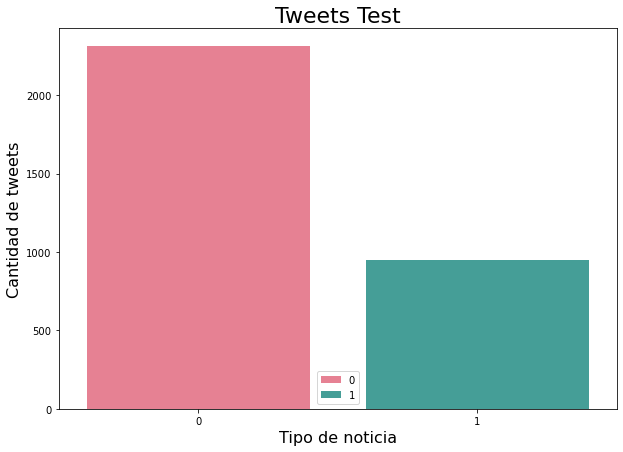

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
g = sns.barplot(x= tweets_submission.target.value_counts().index, y= tweets_submission.target.value_counts().values, orient='v', palette= 'husl', hue= tweets_submission.target.value_counts().index, dodge=False)
g.set_title("Tweets Test", fontsize=22)
g.set_xlabel("Tipo de noticia", fontsize=16)
g.set_ylabel("Cantidad de tweets", fontsize=16)